<a href="https://colab.research.google.com/github/LUJAIN55/crypto-price-prediction-rnn/blob/main/Crypto_Currency_Price_Prediction_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aligreualihassan","key":"ca0ec8c093bf077cf4bb9ed197ec1e56"}'}

In [ ]:
!pip install -U opendatasets -q
import opendatasets

In [ ]:
opendatasets.download("https://www.kaggle.com/datasets/lasaljaywardena/global-cryptocurrency-price-database/")

100%|██████████| 166M/166M [00:01<00:00, 93.9MB/s]


In [ ]:
import os
import pandas as pd
import warnings as w
w.simplefilter('ignore')

path = "/content/global-cryptocurrency-price-database/data"
files = os.listdir(path)

def load_data():
    ''' function to load the data from multiple files in 1 dataframe'''
    data = []
    for file in files:
        f = pd.read_csv(os.path.join(path, file))
        data.append(f)
    return pd.concat(data)

df = load_data()

In [ ]:
df.head()

,Name,Symbol,Date,Open,High,Low,Close,Adj Close,Volume
0,Zilliqa USD,ZIL-USD,2018-01-25,0.136822,0.136822,0.135573,0.136039,0.136039,4921770
1,Zilliqa USD,ZIL-USD,2018-01-26,0.135555,0.159557,0.091337,0.119375,0.119375,13714100
2,Zilliqa USD,ZIL-USD,2018-01-27,0.118157,0.120932,0.091614,0.100976,0.100976,7967360
3,Zilliqa USD,ZIL-USD,2018-01-28,0.101224,0.112499,0.095968,0.097296,0.097296,20910700
4,Zilliqa USD,ZIL-USD,2018-01-29,0.097167,0.099824,0.077958,0.089272,0.089272,12441600


In [ ]:
# check for duplicate values
df.duplicated().sum()

0

In [ ]:
# checking for the missing values
df.isnull().sum()

Name         0
Symbol       0
Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [ ]:
# convert the date attribute from object to datetime data type.
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
# setting the date attribute to being the index of the dataset.
df.set_index('Date', inplace=True)

In [ ]:
df['Volume'] = df['Volume'].astype(int)

In [ ]:
df.shape

(5272108, 8)

In [ ]:
df = df.resample('W').sum() # resample data to be in weaks not in days.

In [ ]:
df = df.select_dtypes('number')
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-21,2186.503975,2228.471420,2067.308151,2120.889431,2120.889431,187559825
2014-09-28,2923.077787,2980.855968,2841.857902,2901.808849,2901.808849,207501757
2014-10-05,2632.505931,2682.245149,2514.553461,2573.197163,2573.197163,301297011
2014-10-12,2470.281281,2586.847860,2403.221308,2528.969776,2528.969776,389047400
2014-10-19,2766.644233,2829.093504,2705.541395,2777.014974,2777.014974,187611793


In [ ]:
df.index.min(), df.index.max()

(Timestamp('2014-09-21 00:00:00', freq='W-SUN'),
 Timestamp('2023-10-15 00:00:00', freq='W-SUN'))

In [ ]:
#### train data : all rows before january 2023.
#### test data : all rows after january 2023

#### all the data before july will be used to train the model to predict the prices for the days after july.

## Train ~80%
## Test ~10%
## Validation : ~10%

In [ ]:
import numpy as np

step = '2023-01-01'

train_data = df.loc['2014-09-21': step]
test_data = df.loc[step :]


train_features, train_target = train_data.drop("Close", axis=1), train_data['Close'].values
test_features, test_target = test_data.drop("Close", axis=1), test_data['Close'].values

# taking the log of the target values to make it normaly distributed.
train_target = np.log(train_target)
test_target = np.log(test_target)

### normalize the features

In [ ]:
# scale the features to set all the values of the columns to be at mean 0 and standard deviation (std) 1.
from sklearn.preprocessing import StandardScaler

s = StandardScaler().set_output(transform="pandas")

train_features = s.fit_transform(train_features)
test_features = s.transform(test_features)

In [ ]:
"""
### the model consist of `8 layers` the first layer is the `input layer` that recieveces the input features.
the second layer is the `rnn layer` tnat extract the relevent features from the inputs with `32 units` followed by `batch normalization` that normalize the features to help the model in training
followed by a `flatten layer` that convert the values into long vector,
dense layer with `64` units and `relu` activation function followed by `batch normalization`
then another `dense layer` with `128 units` and relu activation followed by output `dense layer with 1 units` to get the price

"""

'\n### the model consist of `8 layers` the first layer is the `input layer` that recieveces the input features.\nthe second layer is the `rnn layer` tnat extract the relevent features from the inputs with `32 units` followed by `batch normalization` that normalize the features to help the model in training\nfollowed by a `flatten layer` that convert the values into long vector,\ndense layer with `64` units and `relu` activation function followed by `batch normalization` \nthen another `dense layer` with `128 units` and relu activation followed by output `dense layer with 1 units` to get the price\n\n'

In [ ]:
# prepare the data from the lstm algorithm
import numpy as np
import tensorflow as tf

train= np.expand_dims(train_features, axis=1)
test= np.expand_dims(test_features, axis=1)

def rnn(rnn_units, linear_units):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Input(shape=(1, train_features.shape[1])))
    model.add(tf.keras.layers.SimpleRNN(rnn_units, activation="tanh"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(linear_units, activation="relu"))
    model.add(tf.keras.layers.Dense(linear_units*2, activation="relu"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(1))
    model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam())

    return model

rnn_model = rnn(rnn_units=32, linear_units=64)
print(rnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1216      
                                                                 
 batch_normalization (Batch  (None, 32)                128       
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                       

In [ ]:
"""

## Training the model

# The model predict the next weak close price.

### `Activations` : the rnn activation is the Tanh activation it help preventing the vanishing gradient problem and make the outputs more stable.
#### The dense activation is relu and it is helpful for getting the nonlinear relationships and preventing the vanishing and exploding gradient problems.

### `Loss`: the of the model is The Mean Squared Error and it is the suited loss for regression models.


### `optimizer`: Adam optimizer is an adaptive learning rate optimization algorithm that is widly used in deep learning. It is an extension of the stochastic gradient descent (SGD) algorithm it is very  effiecent because it adaptes the learning rate for each parameter in the model and this allows optimizer to learn at different rates for different parameters, which can lead to faster convergence and better performance.

### `solution to vanshing gradient problem`:
#### The vanishing gradient problem is a problem that can occur when train DL mod=els. It happen when the gradients of the model become so small that they are no longer able to update the weights of the network effectively.
This can make it difficult or impossible for the model to learn. to address the problem we can use different activation function like relu, using batch normalization or using regularization techniques.

"""

'\n\n## Training the model\n\n# The model predict the next weak close price.\n\n### `Activations` : the lstm activation is the Tanh activation it help preventing the vanishing gradient problem and make the outputs more stable.\n#### The dense activation is relu and it is helpful for getting the nonlinear relationships and preventing the vanishing and exploding gradient problems.\n\n### `Loss`: the of the model is The Mean Squared Error and it is the suited loss for regression models.\n\n\n### `optimizer`: Adam optimizer is an adaptive learning rate optimization algorithm that is widly used in deep learning. It is an extension of the stochastic gradient descent (SGD) algorithm it is very  effiecent because it adaptes the learning rate for each parameter in the model and this allows optimizer to learn at different rates for different parameters, which can lead to faster convergence and better performance.\n\n### `solution to vanshing gradient problem`:\n#### The vanishing gradient proble

In [ ]:
# train the model with training data and 10% of the data as a validation data with 100 epoch.
history = rnn_model.fit(train,
                    train_target,
                    validation_split=0.1,
                    epochs=100)

Epoch 1/100
13/13 [==============================] - 8s 29ms/step - loss: 131.1035 - val_loss: 227.9453
Epoch 2/100
13/13 [==============================] - 0s 9ms/step - loss: 125.6368 - val_loss: 221.0582
Epoch 3/100
13/13 [==============================] - 0s 9ms/step - loss: 119.9887 - val_loss: 210.9524
Epoch 4/100
13/13 [==============================] - 0s 8ms/step - loss: 113.9695 - val_loss: 200.5838
Epoch 5/100
13/13 [==============================] - 0s 7ms/step - loss: 106.2208 - val_loss: 188.5810
Epoch 6/100
13/13 [==============================] - 0s 9ms/step - loss: 97.5830 - val_loss: 179.2170
Epoch 7/100
13/13 [==============================] - 0s 9ms/step - loss: 88.0012 - val_loss: 172.7102
Epoch 8/100
13/13 [==============================] - 0s 7ms/step - loss: 77.6490 - val_loss: 154.6113
Epoch 9/100
13/13 [==============================] - 0s 8ms/step - loss: 66.5086 - val_loss: 132.5458
Epoch 10/100
13/13 [==============================] - 0s 9ms/step - loss: 55

## Evaluate LSTM Model
### 1- Mean Squared Error
### 2 - Mean absolute Error

In [ ]:
# compute the Losses for the rnn model to know how well the model is.

from sklearn import metrics
# predict the test dataset.
preds = rnn_model.predict(test)

print(f"RNN MSE is {metrics.mean_squared_error(preds, test_target)}")
print(f"RNN MAE is {metrics.mean_absolute_error(preds, test_target)}")

2/2 [==============================] - 0s 6ms/step
RNN MSE is 0.1501517904031347
RNN MAE is 0.2657273082566037


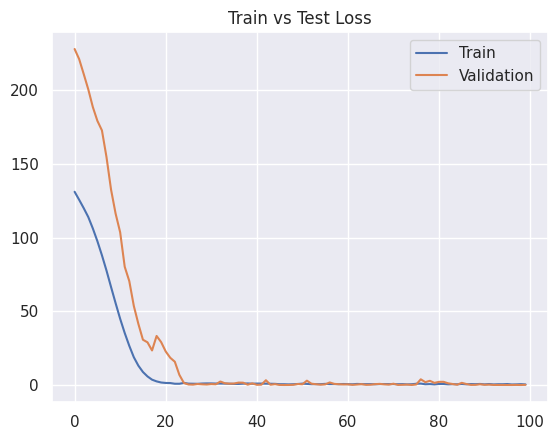

In [ ]:
# plot the train and test Loss for the model to detect overfitting

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

hst = pd.DataFrame(history.history)

plt.plot(hst['loss'], label="Train")
plt.plot(hst['val_loss'], label="Validation")
plt.title("Train vs Test Loss")
plt.legend()
plt.show()

## Predictions

In [ ]:
outputs = pd.DataFrame()
outputs['date'] = test_features.index
outputs['prediction'] = preds

outputs

,date,prediction
0,2023-01-01,15.222987
1,2023-01-08,15.240319
2,2023-01-15,15.366494
3,2023-01-22,15.539043
4,2023-01-29,15.579884
5,2023-02-05,15.607195
6,2023-02-12,15.583204
7,2023-02-19,17.927982
8,2023-02-26,15.705449
9,2023-03-05,15.694190


## Cross Validation

In [ ]:
!pip install scikeras -q
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import KFold, GridSearchCV

import warnings
warnings.simplefilter("ignore")

In [ ]:
''' using cross validation to tune parameters of the model. the parameters of the model is the rnn units and the dense layers
units. we set differnt values for both parameters and run the experiments. we use also the KFokd cross validation of 3 folds to assiss the
model capabilaties and robustness '''

cv_model= KerasRegressor(rnn, rnn_units=16, linear_units=32,epochs=10)

kf = KFold(n_splits=3, shuffle=False)
params ={
    "rnn_units":[10, 20, 32],
    "linear_units":[10, 20, 32]
}

kfold_cross_validation= GridSearchCV(cv_model, params, cv=kf, n_jobs=-1)
kfold_cross_validation.fit(train, train_target)

print(kfold_cross_validation.best_params_)

Epoch 1/10
14/14 [==============================] - 5s 6ms/step - loss: 145.9207
Epoch 2/10
14/14 [==============================] - 0s 6ms/step - loss: 138.3417
Epoch 3/10
14/14 [==============================] - 0s 6ms/step - loss: 134.4716
Epoch 4/10
14/14 [==============================] - 0s 6ms/step - loss: 129.8184
Epoch 5/10
14/14 [==============================] - 0s 7ms/step - loss: 124.7878
Epoch 6/10
14/14 [==============================] - 0s 6ms/step - loss: 119.3466
Epoch 7/10
14/14 [==============================] - 0s 6ms/step - loss: 112.5604
Epoch 8/10
14/14 [==============================] - 0s 6ms/step - loss: 105.3320
Epoch 9/10
14/14 [==============================] - 0s 6ms/step - loss: 97.2403
Epoch 10/10
14/14 [==============================] - 0s 7ms/step - loss: 88.7153
{'linear_units': 32, 'rnn_units': 10}


In [ ]:
"""
### after run the cross validation and hyper parameter tuning the experiments show that out the values
 we used the best params is 10 units for the dense layer and 32 for the rnn units.

"""

'\n### after run the cross validation and hyper parameter tuning the experiments show that out the values\n we used the best params is 64 units for the dense layer and 16 for the rnn units. \n\n'